# Monitoring Wetlands in Africa

* **Products used:**
[usgs_ls8c_level2_2](), 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[ga_ls8c_fractional_cover_2]()

### Background

According to [Wetlands International](https://africa.wetlands.org/en/wetlands/what-are-wetlands/), Africa’s wetlands ecosystems are estimated to cover 131 million hectares, and include some of the most productive and biodiverse ecosystems in the world. They provide a host of ecosystem services that contribute to human well-being through nutrition, water supply and purification, climate and flood regulation, coastal protection, feeding and nesting sites for animals, recreational opportunities and increasingly, tourism.  As such, the health of wetland ecosystems has been identified as an important metric for the `Sustainable Development Goals` ([6.6.1 Change in the extent of water-related ecosystems over time](https://www.sdg6monitoring.org/indicator-661/)). 

The `Wetlands Insight Tool (WIT)` provides at a glance insights into a wetland's dynamics. The WIT is a spatiotemporal summary of an wetland that combines multiple datasets derived from the African Landsat archive held within DE Africa. `Fractional cover`, `WOfS`, and `surface reflectance` data are retrieved from DE Africa and combined to produce a stack plot describing the percentage of a wetland polygon as vegetation fractional cover, open water, and wet vegetation through time.  

> `Detailed Explanation:`
Data is retrieved for timesteps containing more than 90% cloud-free data (you can adjust this number in the code below). The code calculates the Tasselled-Cap Wetness (TCW, or just 'wetness') from surface reflectance and takes the maximum Fractional cover fraction per pixel, masking Fractional cover with TCW, and masking TCW with open water. For each pixel inside or overlapping the polygon describing the wetland, WIT calculates the dominant fractional cover type. The fractional cover algorithm calculates the BS, PV and NPV for each pixel as a percentage. WIT selects the largest percentage value for each pixel as the dominant fractional cover type. Fractional cover was masked using WOfS and TCW to remove areas of water and wet vegetation from areas where fractional cover is calculated. This is necessary as the fractional cover algorithm erroneously classifies water as green vegetation (PV). The resulting output is a stacked plot of open water, wet vegetation, photosynthetic vegetation, non-photosynthetic vegetation, and bare soil for the wetland polygon through time.

### Description
This notebook will run the Wetlands Insight Tool for the area encompassed by a polygon. This notebook uses a default shapefile that provides an example wetland for running the analysis. The polygons in this shapefile were hand drawn from a basemap, and they are only provided for demonstration purposes, they are not meant to represent the true delineation of any specific wetland.

1.  Load in a shapefile
2.  Select an individual polygon from the shapefile
3.  Run the Wetlands Insight Tool
4.  Plot the results as a stacked line plot
5.  Create a true colour animation of the wetland alongside the stack plot

<!-- 6.  Use the WIT tool to create a per-pixel classification of the wetland -->
<!-- 7.  Generate a second animation comparing the per-pixel classification to the true colour timeseries -->


> **Note: This analysis unavoidably uses a lot of memory, and thus it cannot be conducted over large areas and for long time-series. If you experience `kernel restarting` problems, consider reducing the length of the time-series, and/or reducing the spatial extent of the analysis**

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

### Load packages

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import datacube
from datacube.utils import geometry

sys.path.append('../Scripts')
import deafrica_wetlandtools
import deafrica_datahandling
from deafrica_plotting import map_shapefile

%load_ext autoreload
%autoreload 2


## Analysis parameters

The following cell sets important parameters for the analysis:

* `shp_path`: a location path to the shapefile (e.g. `folder/input.shp`). 

* `time_range`: The date range to analyse (e.g. `('2015', '2019') `)

In [9]:
shp_path = '../Supplementary_data/Wetlands_insight_tool/WIT_example_polygons.shp'

time_range = ('2015-01' , '2019-12')

### Load shapefile

We will also ensure the polygon is in WGS84 coordinates (`epsg=4326`) using the `to_crs()` method to make sure it can index the datacube correctly.

In [10]:
gdf = gpd.read_file(shp_path).to_crs({'init': 'epsg:4326'}) 
gdf

,Name,geometry
0,Lake_Fitri,"POLYGON ((17.48823 12.98059, 17.58475 12.88522..."
1,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."


### Select an individual polygon

We can do this by specifying the name of the polygon we want to interrogate.

In [12]:
wetland_name = 'Lac_de_Korienze'

#index the gdf by the wetland name
poly = gdf[gdf.Name == wetland_name]
poly

,Name,geometry
1,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."


In [15]:
map_shapefile?

Signature:
map_shapefile(
    gdf,
    attribute,
    continuous=False,
    colormap='YlOrRd_09',
    basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 'max_zoom': 20, 'attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', 'name': 'Esri.WorldImagery'},
    default_zoom=None,
    hover_col=True,
    **style_kwargs,
)
Docstring:
Plots a geopandas GeoDataFrame over an interactive ipyleaflet 
basemap, with features coloured based on attribute column values. 
Optionally, can be set up to print selected data from features in 
the GeoDataFrame. 
Last modified: February 2020
Parameters
----------  
gdf : geopandas.GeoDataFrame
    A GeoDataFrame containing the spatial features to be plotted 
    over the basemap.
attribute: string, required
    An required string giving the name of any column in the
    GeoDataFrame you wish to h

In [16]:
map_shapefile(poly, 'Name', fillOpacity=0.1)

NameError: name 'linear' is not defined

### Run the Wetlands Insight Tool

Even for small areas, this code can take a long time to run so you will need to be patient. This is because the tool loads three seperate datasets (Landsat SR, Fractioanl Cover, and WOfS), and calculates a tasselled cap index on the fly. 

In [5]:
wetlands_df = deafrica_wetlandtools.WIT_drill(gdf_poly=poly,
                                              time=time_range,
                                              min_gooddata=0.80,
                                              TCW_threshold=-6000,
                                              export_csv=wetland_name+'_WIT.csv')

wetlands_df.head()

working on polygon: [['Lac_de_Korienze']].  
Loading usgs_ls8c_level2_2 data
    Using pixel quality parameters for USGS Collection 2
    Filtering to 74 out of 301 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 74 observations 
size of wetlands array: (500, 519)
calculating tasseled cap index 
Loading WOfS layers 
Loading fractional Cover
Generating classification
exporting csv: Lac_de_Korienze_WIT.csv


,wofs_area_percent,wet_percent,green_veg_percent,dry_veg_percent,bare_soil_percent
2015-01-16 10:37:38.956071,35.11,2.92,0.66,34.57,26.75
2015-02-01 10:37:34.789335,39.11,3.35,0.46,28.63,28.45
2015-02-17 10:37:26.524249,36.70,2.04,0.60,33.04,27.61
2015-03-05 10:37:21.243305,31.04,1.31,0.03,37.58,30.04
2015-04-22 10:36:59.039345,15.81,0.50,0.07,53.16,30.46


## Plot the results

If you would like to export the plot as a .png file, then set the variable below to `True`, and give the plot a `name` (e.g. the wetland's name)

In [6]:
export_plot = True
name = 'Lac_de_Korienze_WIT'

<Figure size 432x288 with 0 Axes>

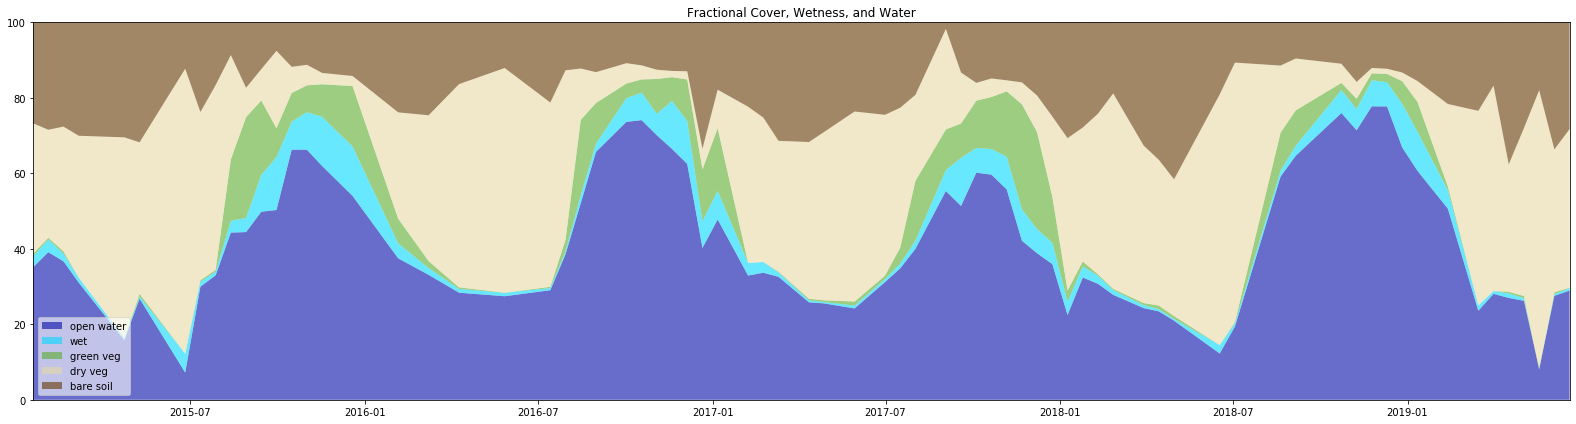

In [7]:
df = wetlands_df

# generate plot
warnings.filterwarnings("ignore")
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (22,6))
plt.stackplot(df.index, 
              df.wofs_area_percent, 
              df.wet_percent, 
              df.green_veg_percent, 
              df.dry_veg_percent,
              df.bare_soil_percent,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)

#set axis limits to the min and max
plt.axis(xmin = df.index[0], xmax = df.index[-1], ymin = 0, ymax = 100)

#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
plt.title('Fractional Cover, Wetness, and Water')
plt.tight_layout()
if export_plot:
    #save the figure
    plt.savefig(f'{name}.png')#, transparent=True)


***

## Animating the wetland timeseries

Using clear satellite observations over the wetland, we can animate a true-colour satellite image time-series alongside an animation of the WIT stack plot.  This can help us visualise how the wetland has changed over time.

### Set up the datacube query

In [8]:
dc = datacube.Datacube(app='rgb_animation')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

In [10]:
# Create a query object from the same polygon
# we used for the WIT drill
geom = geometry.Geometry(
        poly.geometry.values[0].__geo_interface__,
        geometry.CRS(
            "epsg:4326")
    )

query = {
    'geopolygon': geom,
    'time': time_range,
    'resolution': (-30,30),
    'group_by': 'solar_day'
}

# find the correct UTM CRS for the location
crs = deafrica_datahandling.mostcommon_crs(dc=dc,
                                          product='usgs_ls8c_level2_2',
                                          query=query)

### Load USGS Landsat data

In [11]:
#Load clear USGS C2 data
col2 = deafrica_datahandling.load_masked_usgs(dc=dc,
                                            min_gooddata=0.8,# this number must match WIT_drill
                                            products=['usgs_ls8c_level2_2'],
                                            output_crs=crs,
                                            measurements=['red', 'green', 'blue'],
                                            align=(15, 15),
                                            **query)

Loading usgs_ls8c_level2_2 data
    Using pixel quality parameters for USGS Collection 2
    Filtering to 74 out of 202 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 74 observations 


### Animate true-colour and WIT plot

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


    Exporting animation to Lac_de_Korienze_WIT.gif


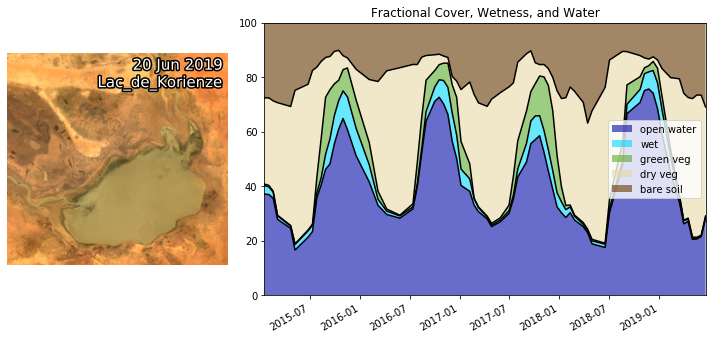

In [12]:
deafrica_wetlandtools.animated_timeseries_WIT(
    col2.rolling(time=3, center=True, min_periods=1).mean(),
    df.rolling(window=3, center=True, min_periods=1).mean(),
    name + "_WIT.gif",
    width_pixels=1000,
    interval=300,
    show_date=True,
    annotation_kwargs={'fontsize': 15},
    title= name,
)